<font color="red"><h1>OpenSees Examples Manual using OpenSeesPy!</h1></font>
<h2><u>OpenSees Example 1b</u></h2>
<h2>Elastic Portal Frame -- Static Pushover</h2>

You can find the original OpenSees examples manual using Tcl [here](https://opensees.berkeley.edu/wiki/index.php/Examples_Manual). (Original Examples in Tcl by Silvia Mazzoni & Frank McKenna, 2006.)

<h2><u>Simulation Process</u></h2>

In the following example, an input file (python script) is created to conduct a simulation in OpenSees. The process of creating the input file is broken-down into the following parts: 
### 1. Model definition
### 2. Output specification
### 3. Loads and Analysis
- Define gravity loads
- Analyse gravity loads
- Define lateral loads
- Analyse lateral loads

<h1> OpenSees Examples Manual Examples for OpenSeesPy</h1>
<h2>OpenSees Example 1b. Elastic Portal Frame -- Static Pushover</h2>

<h2> Simulation Process</h2>

Each example script does the following:
<h3>A. Build the model</h3>
<ol>
    <li>model dimensions and degrees-of-freedom</li>
    <li>nodal coordinates</li>
    <li>nodal constraints -- boundary conditions</li>
    <li>nodal masses</li>
    <li>elements and element connectivity</li>
    <li>recorders for output</li>
</ol>
<h3>B. Define & apply gravity load</h3>
<ol>
    <li>nodal or element load</li>
    <li>static-analysis parameters (tolerances & load increments)</li>
    <li>analyze</li>
    <li>hold gravity loads constant</li>
    <li>reset time to zero</li>
</ol>
<h3>C. Define and apply lateral load</h3>
<dl>
<li>Time Series and Load Pattern (nodal loads for static analysis, support ground motion for earthquake)</li>
<li>lateral-analysis parameters (tolerances and displacement/time increments)</li>
<b>Static Lateral-Load Analysis</b>
<li>define the displacement increments and displacement path</li>
<b>Dynamic Lateral-Load Analysis</b>
<li>define the input motion and all associated parameters, such as scaling and input type</li>
<li>define analysis duration and time increment</li>
<li>define damping</li>
<li>analyze</li>
<p>    
    
<b>Introductory Examples</b>
The objective of Example 1a and Example 1b is to give an overview of input-file format in OpenSees using simple scripts.


<h1> OpenSees Example 1b. <br>
    2D Elastic Portal Frame -- Static Pushover</h1>
Introduction

<b> Example 1b introduces the use of</b>
- Two element types <br>
- Distributed element loads <br>

<img src="https://opensees.berkeley.edu/wiki/images/5/59/Example1b_Push.GIF">


In [6]:
# Import required modules
import openseespy.opensees as ops  # OpenSeesPy: The Python interface for OpenSees, used for finite element analysis.
import opsvis as opsv  # Visualization tool for OpenSees models.
import os  # Provides functions for interacting with the operating system.
import numpy as np # Python library used for scientific computing
import matplotlib.pyplot as plt  # Plotting library for data visualization.

In [7]:
# Check if a directory named 'Data' exists; if not, create one.
# This directory will store any data or results generated during the simulation.
if not os.path.exists('Data'): 
    os.mkdir('Data')

## Units

In [8]:
# all units are in kip, inch, second


# Defining base units for the simulation.
m = 1.0  # Meter (base unit for length)
s = 1.0  # Second (base unit for time)
kg = 1.0  # Kilogram (base unit for mass)

# Derived units for force and pressure.
N = kg * m / s ** 2  # Newton (unit of force)
Pa = N / m ** 2  # Pascal (unit of pressure)

# Additional conversions for different units commonly used in structural engineering.
inches = 0.0254 * m  # Conversion factor for inches to meters.
ft = 12 * inches  # Conversion factor for feet to meters.
kip = 4448.2216152548 * N  # Conversion factor for kips (1000 pounds-force) to Newtons.
ksi = 6.895 * 10 ** 6 * Pa  # Conversion factor for ksi (1000 psi) to Pascals.

## Input Variables

In [9]:
# colL = 36 * ft # Column length
beam_length = 42.0 * ft
column_length = 36.0 * ft

# Nodal coordinates
n1 = (0.0, 0.0) # Use floating point values
n2 = (beam_length, 0.0)
n3 = (0.0, column_length)
n4 = (beam_length, column_length)

# # Cross-sectional dimensions
# b = 5 * ft # Breadth
# d = 5 * ft # Depth
# A = b * d # Area

# # Elastic Modulus
# E = 4227 * ksi

# # Moment of Inertia
# Iz = (b * d ** 3) / 12

# Loads/Actions
Py = -4000.0 * kip # Gravity load
w = Py / beam_length # Uniformly distributed load (N/m)

In [10]:
# Px = 1 # Lateral load

g = 9.81 # Gravitational acceleration (N / kg)

# Nodal mass
mass_x = abs(Py) / g # kg
print(f'The nodal mass value corresponding to the horizontal DOF is {mass_x:.0f} kg') # 
massValues = [mass_x, 1 * 10 ** -9, 0.0] # ndf nodal mass values corresponding to each DOF

The nodal mass value corresponding to the horizontal DOF is 1813750 kg


## Model definition

Text(0.5, 1.0, 'plot_model after defining elements')

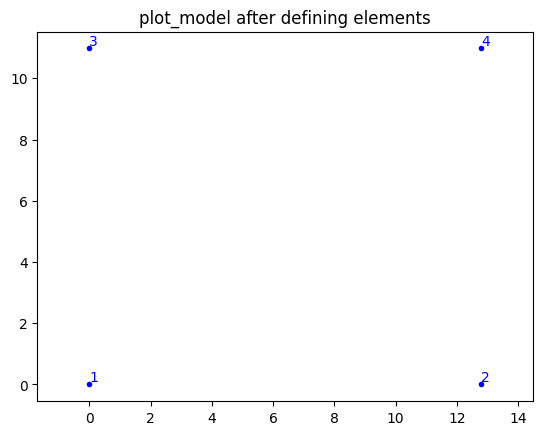

In [11]:
ops.wipe() # Clear opensees model
ops.model('basic','-ndm',2,'-ndf',3)     #  # 2D model with 3 degrees of freedom per node.

# define GEOMETRY -------------------------------------------------------------

# Create nodes
nodal_crds = (n1, n2, n3, n4)
for nodeTag, crds in enumerate(nodal_crds, start = 1): # https://docs.python.org/3/library/functions.html#enumerate
    ops.node(nodeTag, *crds)


# Plot Model
opsv.plot_model()
plt.title('plot_model after defining elements')

In [12]:
# Single point constraints -- Boundary Conditions
fully_fixed = [1, 1, 1]
free = [0, 0, 0]

ops.fix(1, *fully_fixed)     #  node DX DY RZ
ops.fix(2, *fully_fixed)     #  node DX DY RZ
ops.fix(3, *free)
ops.fix(4, *free)

# nodal masses:
ops.mass(3,5.18,0.,0.)     #  node , Mx My Mz, Mass=Weight/g.
ops.mass(4,5.18,0.,0.)

# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness and resisting force from the basic system to the global-coordinate system
ops.geomTransf('Linear',1)     #  associate a tag to transformation

# connectivity: (make A very large, 10e6 times its actual value)
ops.element('elasticBeamColumn',1,1,3,3600000000,4227,1080000,1)     #  element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn',2,2,4,3600000000,4227,1080000,1)
ops.element('elasticBeamColumn',3,3,4,5760000000,4227,4423680,1)

# Define RECORDERS -------------------------------------------------------------
ops.recorder('Node','-file','Data/DFreeEx1bPush.out','-time','-node',3,4,'-dof',1,2,3,'disp')     #  displacements of free nodes
ops.recorder('Node','-file','Data/DBaseEx1bPush.out','-time','-node',1,2,'-dof',1,2,3,'disp')     #  displacements of support nodes
ops.recorder('Node','-file','Data/RBaseEx1bPush.out','-time','-node',1,2,'-dof',1,2,3,'reaction')     #  support reaction
ops.recorder('Element','-file','Data/FColEx1bPush.out','-time','-ele',1,2,'globalForce')     #  element forces -- column
ops.recorder('Element','-file','Data/FBeamEx1bPush.out','-time','-ele',3,'globalForce')     #  element forces -- beam

# define GRAVITY -------------------------------------------------------------
ops.timeSeries('Linear',1)     # timeSeries Linear 1;
# define Load Pattern
ops.pattern('Plain',1,1) # 
ops.eleLoad('-ele',3,'-type','-beamUniform', w)     #  distributed superstructure-weight on beam

ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.constraints('Plain')     #  how it handles boundary conditions
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.analysis('Static')     #  define type of analysis static or transient
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

# define LATERAL load -------------------------------------------------------------
# Lateral load pattern
ops.timeSeries('Linear',2)     # timeSeries Linear 2;
# define Load Pattern
ops.pattern('Plain',2,2) # 
ops.load(3,2000.,0.0,0.0)     #  node , FX FY MZ -- representative lateral load at top nodes
ops.load(4,2000.,0.0,0.0)     #  place 1/2 of the weight for each node to get shear coefficient
 
# pushover: diplacement controlled static analysis
ops.integrator('DisplacementControl',3,1,0.1)     #  switch to displacement control, for node 11, dof 1, 0.1 increment
ops.analyze(100)     #  apply 100 steps of pushover analysis to a displacement of 10

print('Done!')





Done!


End of Run: pyEx1b.Portal2D.Push.tcl.py


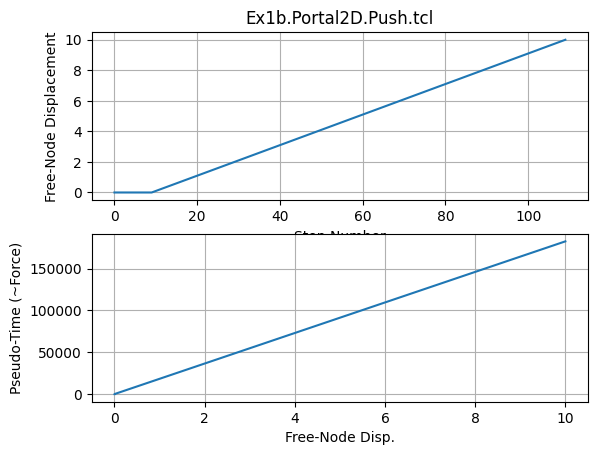

In [14]:
ops.wipe() # the wipe command here closes all recorder files
plt.close('all')
fname3 = 'Data/DFreeEx1bPush.out'
dataDFree = np.loadtxt(fname3)
plt.subplot(211)
plt.title('Ex1b.Portal2D.Push.tcl')
plt.grid(True)
plt.plot(dataDFree[:,1])
plt.xlabel('Step Number')
plt.ylabel('Free-Node Displacement')
plt.subplot(212)
plt.grid(True)
plt.plot(dataDFree[:,1],dataDFree[:,0])
plt.xlabel('Free-Node Disp.')
plt.ylabel('Pseudo-Time (~Force)')
print('End of Run: pyEx1b.Portal2D.Push.tcl.py')